In [1]:


from matplotlib import pyplot as plt
"""
This notebook generates the figures presented in the paper. If other data should be used the paths in the cells need to be adapted
"""
import os
import sys

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "axes.grid" : True,
    "axes.linewidth": 0.75,
    "pgf.preamble": "\n".join([r'\usepackage{amsmath}', r'\usepackage{bm}', r'\usepackage{amsfonts}', r'\usepackage{amssymb}'])
})
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{bm} \usepackage{amsfonts} \usepackage{amssymb}')

parent_dir =  os.path.dirname(os.getcwd())

pts2inch = 1/72.27
ratio = 1.618
max_pts = 433
frac = 0.6

100%|██████████| 161/161 [00:00<00:00, 349.63it/s]
/home/jannis/.local/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Norm difference of posterior means: 0.015747680046858222
Correlation Matrix: tensor([[1.0000, 0.3367],
        [0.3367, 1.0000]])
Uncertainty at supplementary task: 6.4103134849430905
lambda:1.883515610562921
gamma: 1.208343441759214
sqrtbeta: 6.803428675298156
sqrtbeta: 6.803428675298156


  0%|          | 0/100 [00:00<?, ?it/s]/home/jannis/.local/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


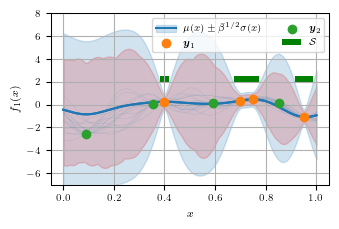

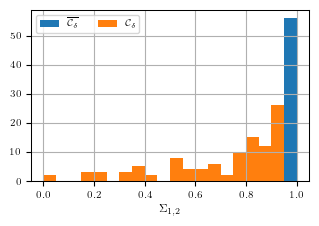

violations: 0.0%


tensor(0.)

In [8]:


def plot_post(mu, l, u, test_x, train_data = None, tasks=[0], ground_truth = None):
    handles = []
    labels = []
    test_x = test_x.squeeze().detach().numpy()
    u = u.squeeze().detach().numpy()
    l = l.squeeze().detach().numpy()
    fig,ax = plt.subplots(figsize=(max_pts*frac*pts2inch,max_pts*frac/ratio*pts2inch))
    fill = ax.fill_between(test_x, u, l, alpha=0.2, color="C0")
    if mu is not None:
        mu = mu.squeeze().detach().numpy()
        mu_line, = ax.plot(test_x, mu, "C0")
        handles.append((mu_line,fill))
        labels.append(r'$\mu(x)\pm \bar{\beta}^{1/2}\sigma(x)$')
    if ground_truth is not None:
        gt_line, = ax.plot(ground_truth[0], ground_truth[1], "--k", alpha = .4)
        handles.append(gt_line)
        labels.append('ground truth')
        
    if train_data is not None:
        if len(train_data) >= 2:
            train_tasks = train_data[1]
            scat = [ax.scatter(train_data[0][train_tasks==i], train_data[2][train_tasks==i],c=f'C{i+1}',zorder=10) for i in tasks]
        else:
            scat = ax.scatter(train_data[0], train_data[2],c='C1',zorder=10)
        handles.extend(scat)
        labels.extend([r'$\bm{{y}}_{{{val}}}$'.format(val = str(i+1)) for i in tasks]) 
    T = 2.
    S = ax.fill_between(test_inputs,2,2.5,where=u<=T, facecolor='green')
    handles.append(S)
    labels.extend([r'$\mathcal{S}$'])
    ax.set_ylim(-7,8)
    ax.legend(handles,labels,loc='upper right',ncol=2)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$f_1(x)$")
    return ax,fig

def batch_posterior(samps_mod,test_x):
    test_x=torch.hstack((test_x.unsqueeze(-1),torch.zeros_like(test_x).unsqueeze(-1))).unsqueeze(0)
    covar_size = samps_mod.task_covar_module.covar_factor.size(0)
    K = samps_mod.forward(test_x.repeat(covar_size,1,1))


from tqdm import tqdm
from numpy import load
sys.path.append(parent_dir)
import utils.utils
import utils.get_robust_gp
import torch 


torch.set_default_dtype(torch.float64)

with open(parent_dir+"/data/plots/data_for_diff_beta2.npy", 'rb') as f:
    sample_models,gp,norm_bounds = load(f,allow_pickle=True).item().values()
f.close()
norm_train_inputs = gp.train_inputs[0]
train_tasks = norm_train_inputs[:,-1].view(-1,1)
norm_train_inputs = norm_train_inputs[:,:-1].view(-1,1)
norm_train_targets = gp.train_targets.view(-1,1)
tau = 0.005
delta_max = 0.3
rho_max = 0.05
test_inputs = torch.linspace(0,1,round(1/tau))

def get_violation(delta_max, plot=False):
    robust_gp,sqrtbeta, covar_set, totals = utils.get_robust_gp.bayesian_robust_gp(sample_models,gp,norm_bounds,delta_max=delta_max,tau = tau, conservatism=True, rho_max=rho_max)
    robust_gp.train()
    robust_gp(torch.hstack((norm_train_inputs,train_tasks)))
    posterior = robust_gp.posterior(test_inputs.reshape( -1, 1, 1), output_indices=[0])
    ymean = posterior.mean.squeeze().detach()
    std_dev = posterior.variance.squeeze().sqrt()

    print(f"sqrtbeta: {sqrtbeta}")
    u = ymean + sqrtbeta * std_dev
    l = ymean - sqrtbeta * std_dev

    post_samps = posterior.sample(torch.Size([1000])).squeeze().detach()
    u1 = post_samps.max(dim=0)[0]
    l1 = post_samps.min(dim=0)[0]
    chol_covars = sample_models.task_covar_module.covar_factor.detach()
    counter = 0
    fact = 100
    posterior_all = sample_models.posterior(test_inputs.reshape( 1, -1, 1), output_indices=[0])
    num_samples = 100
    for i in tqdm(range(fact)):
        new_samps = posterior_all.sample(torch.Size([num_samples]))[:,:,:].view(-1,test_inputs.size(0))
        # s.append(new_samps)
        counter += torch.any((new_samps > u) | (new_samps < l),dim=-1).sum()
        u1 = torch.maximum(new_samps.max(dim=0)[0],u1)
        l1 = torch.minimum(new_samps.min(dim=0)[0],l1)
    if plot:
        ax,fig = plot_post(ymean,l,u,test_inputs,(norm_train_inputs,train_tasks,norm_train_targets),tasks=[0,1])
        ind = torch.randint(0,new_samps.size(0),(15,))
        ax.plot(test_inputs, ymean, "C0")
        ax.fill_between(test_inputs, u1.detach(), l1.detach(), alpha=0.2, color="C3")
        ax.plot(test_inputs.view(-1,1).detach().numpy(), new_samps[ind,:].T.detach().numpy(), "C0",linewidth=0.1, alpha=0.5)
        fig.savefig(parent_dir+"/plots/post_samples1.pdf", bbox_inches='tight')

        fig2,ax2 = plt.subplots(1,1,figsize=(max_pts*frac*pts2inch,max_pts*frac/ratio*pts2inch))
        cov_vals = covar_set[:,1,0]
        ax2.hist(chol_covars[:,1,0],bins=torch.linspace(0,1,21), label=r"$\overline{\mathcal{C}_\delta}$")
        ax2.hist(cov_vals,color='C1',bins=torch.linspace(0,0.95,20), label = r"$\mathcal{C}_\delta$")
        ax2.set_xlabel("$\Sigma_{1,2}$")
        ax2.set_ylabel(r"\ ")
        ax2.legend(ncol=2)
        plt.show()
        fig2.tight_layout()
        fig2.savefig(parent_dir+"/plots/post_density01.pdf", bbox_inches='tight')

    freq = counter/(fact*new_samps.size(0))
    perc = round(100*freq.item(),3)
    print(f"violations: {perc}%")
    return freq

get_violation(delta_max,plot=True)



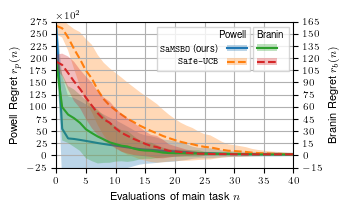

In [ ]:
import pickle
import torch

glob_opt = {"Branin": 0.397887, "Powell": 0}

fig,ax = plt.subplots(1,figsize=(max_pts*frac*pts2inch,max_pts*frac/ratio*pts2inch))
files = [parent_dir+"/data/SaMSBO/Powell.obj",
         parent_dir+"/data/SafeUCB/Powell.obj",
         parent_dir+"/data/SaMSBO/Branin.obj",
         parent_dir+"/data/SafeUCB/Branin.obj"]

def plot2(ax,str,i):
    if str.find('.obj') != -1:
        with open(str,'rb') as file:
            data = pickle.load(file)
            best_values = -torch.tensor([y[-1] for y in data['bests']])
            best_values -= -glob_opt["Branin"] if "Branin" in str else 0
            stdy,muy = torch.std_mean(best_values,dim=0)
    x = torch.arange(len(muy))
    fill = ax.fill_between(x,muy+stdy,muy-stdy,color=f"C{i}",alpha=.3, linewidth=0)
    line,= ax.plot(x,muy, color=f"C{i}",linestyle = '--' if (i+1)%2==0 else '-')

    return (line,fill)

h = []
for i in range(len(files)//2):
    h.append(plot2(ax,files[i],i))
ax2 = ax.twinx()
for i in range(len(files)//2,len(files)):
    h.append(plot2(ax2,files[i],i))
   
leg = ax.legend(h[:2],[r"\texttt{SaMSBO} (ours)",r"\texttt{Safe-UCB"], markerfirst=False, markerscale= 1.5, title="Powell", title_fontsize=7, loc='upper right', bbox_to_anchor=(.839, 1.),fancybox=False)
leg._legend_box.align = "right"
leg2 = ax2.legend(h[2:],["",""], title="Branin", loc='upper right',title_fontsize=7,markerscale= 1,fancybox=False)
leg2._legend_box.align = "right"
ax.set_xlabel(r"Evaluations of main task $n$")
ax.set_xlim(0,40)
ymin2 = -15; ymax2 = 165
ymin1 = -2500; ymax1 = 27500
n_ticks = 13
ax.set_yticks(torch.linspace(ymin1,ymax1,n_ticks))
ax2.set_yticks(torch.linspace(ymin2,ymax2,n_ticks))
ax.set_ylim(ymin1,ymax1)
ax2.set_ylim(ymin2,ymax2)
ax.set_ylabel(r"Powell Regret $r_p(n)$")
ax2.set_ylabel(r"Branin Regret $r_b(n)$")
ax.ticklabel_format(axis='y',style='sci',scilimits=(2,2))
ax2.grid(False)
fig.tight_layout()
plt.show()
fig.savefig(f"../plots/synthetic_fun_comp.pdf", bbox_inches='tight')

violations: tensor([0])
violations: tensor([0])
violations: tensor([23])
violations: tensor([71])


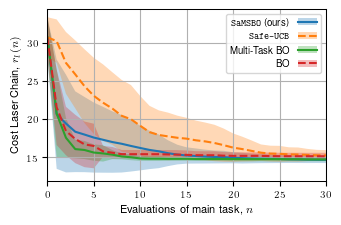

In [5]:
import pickle
import torch


fig,ax = plt.subplots(1,figsize=(max_pts*frac*pts2inch,max_pts*frac/ratio*pts2inch))
files = [parent_dir+"/data/SaMSBO/LbSync.obj",
         parent_dir+"/data/SafeUCB/LbSync.obj",
         parent_dir+"/data/MTBO/LbSync.obj",
         parent_dir+"/data/BO/LbSync.obj"]

def plot2(ax,str,i):
    if str.find('.obj') != -1:
        with open(str,'rb') as file:
            data = pickle.load(file)
            best_values = -torch.tensor([y[-1] for y in data['bests']])
            stdy,muy = torch.std_mean(best_values,dim=0)
            vios = 0
            for set in data['data_sets']:
                xt,tt,yt = tuple(set)
                xt0 = xt[tt.squeeze() == 0]
                yt0 = yt[tt.squeeze() == 0]
                vios += sum(-yt0>40)
            print(f"violations: {vios}")
    x = torch.arange(len(muy))
    fill = ax.fill_between(x,muy+stdy,muy-stdy,color=f"C{i}",alpha=.3, linewidth=0)
    line,= ax.plot(x,muy, color=f"C{i}",linestyle = '--' if (i+1)%2==0 else '-')
    return (line,fill)

h = []
for i in range(len(files)):
    h.append(plot2(ax,files[i],i))

   
leg = ax.legend(h,[r"\texttt{SaMSBO} (ours)",r"\texttt{Safe-UCB",r"Multi-Task BO",r"BO"], markerfirst=False, title_fontsize=7, loc='upper right')
ax.set_xlim(0,30)
ax.set_xlabel(r"Evaluations of main task, $n$")
ax.set_ylabel(r"Cost Laser Chain, $r_l(n)$")
fig.savefig("../plots/laser_chain_comp.pdf", bbox_inches='tight')